In [21]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import os
import urllib
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
import seaborn as sns

In [22]:
class CustomLoader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir=os.path.join(os.getcwd(), "data")):
        super(CustomLoader, self).__init__()
        self.raw_data_dir = raw_data_dir
        self._read_web_data()

    def _download_url(self, url, save_path):  # pragma: no cover
        with urllib.request.urlopen(url) as dl_file:
            with open(save_path, "wb") as out_file:
                out_file.write(dl_file.read())

    def _read_web_data(self):
        url = "https://graphmining.ai/temporal_datasets/METR-LA.zip"

        # Check if zip file is in data folder from working directory, otherwise download
        if not os.path.isfile(
            os.path.join(self.raw_data_dir, "METR-LA.zip")
        ):  # pragma: no cover
            if not os.path.exists(self.raw_data_dir):
                os.makedirs(self.raw_data_dir)
            self._download_url(url, os.path.join(self.raw_data_dir, "METR-LA.zip"))

        if not os.path.isfile(
            os.path.join(self.raw_data_dir, "adj_mat.npy")
        ) or not os.path.isfile(
            os.path.join(self.raw_data_dir, "node_values.npy")
        ):  # pragma: no cover
            with zipfile.ZipFile(
                os.path.join(self.raw_data_dir, "METR-LA.zip"), "r"
            ) as zip_fh:
                zip_fh.extractall(self.raw_data_dir)

        A = np.load(os.path.join(self.raw_data_dir, "adj_mat.npy"))
        X = np.load(os.path.join(self.raw_data_dir, "node_values.npy")).transpose(
            (1, 2, 0)
        )
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, num_timesteps_in: int = 12, num_timesteps_out: int = 12
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset



In [23]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.13.1


In [24]:


loader = CustomLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
#print("Number of samples / sequences: ",  len(dataset))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7fc29fc59250>


In [25]:
dataset[0]

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [26]:
len(list(iter(dataset)))

34249

In [27]:
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [28]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(iter((train_dataset)))))
print("Number of test buckets: ", len(list(iter((test_dataset)))))

Number of train buckets:  27399
Number of test buckets:  6850


In [29]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [30]:
# GPU support
from tqdm import tqdm
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in tqdm(range(3)): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
            break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.7664


In [ ]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


<Axes: >

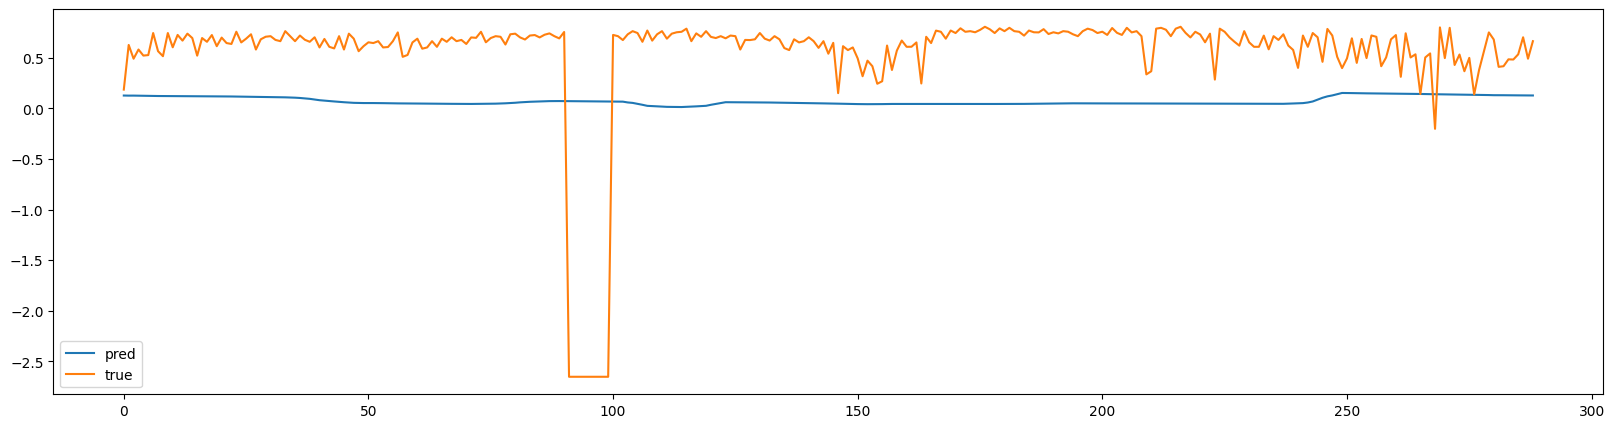

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")